# Imports

In [1]:
import logging
import numpy as np
import pandas as pd
# from src import pipeline
import stumpy
from src import common, peak_detection
# from src.outlier_model import OutlierModel
import matplotlib.pyplot as plt

logging.basicConfig(format='%(asctime)s: %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p')
logger = logging.getLogger("TimeSeries")
logger.setLevel(logging.INFO)

# Dataset preprocessing

In [2]:
column_types_loc = "#datasets/Colab_PowerConverter/column_types.json"
column_types = common.json_load(column_types_loc)

target = column_types["target"]
identifier = column_types["identifier"]
cat_cols = column_types["categorical"]
measurement_label = column_types["measurement_label"]

data = pd.read_pickle(
    f"#datasets/Colab_PowerConverter/dataset.pkl"
)

# this measurement did not have a fault (?)
data = data[data[measurement_label]!="Single-Phase_Sensor_Fault"]
data.reset_index(inplace=True, drop=True)

# assign unique label to each measurement fault and create dictionary for easier analysis
fault_dict = {}
for label,i in zip(data[measurement_label].unique(), range(len(data[measurement_label].unique()))):
    data.loc[(data[measurement_label]==label) & (data[target]==1), target] = int(i+1)
    fault_dict[label] = int(i+1)

data.drop(columns=[measurement_label], inplace=True)
# Fill NA - 0 for numerical and 'NA' for categorical
# categorical
data[cat_cols] = data[cat_cols].fillna("NA")
data[cat_cols] = data[cat_cols].astype(str)
# non-categorical
non_cat_cols = data.drop(columns=cat_cols + [identifier]).columns.tolist()
data[non_cat_cols] = data[non_cat_cols].fillna(0)


# Train model

In [3]:
# task = "multiclass"
#
# column_types_loc = "#datasets/Colab_PowerConverter/column_types.json"
# save_loc = "models.dill"
#
# parameters = {
#     "random_state": 1,
#     "test_size_train": 0.2,
#     "test_size_valid": 0.5,
#     "scaler": "Standard",
# }
#

In [4]:
# (
#     data_train_scaled,
#     data_valid_scaled,
#     data_test_scaled,
#     models,
# ) = pipeline.train(task,data, column_types_loc, parameters, save_loc=save_loc, verbose=True, datasets=True)
#

In [5]:
# predicted = pipeline.predict(data, column_types_loc, save_loc)

# Outlier_model
* outlier_model code that implementes outlier_model.predict() function

In [98]:
class OutlierModel:
    """Object used to define outlier network designs"""

    def __init__(
            self,
            m: int = 15,
            std_dev: int = 3,
            time_series=None,
            egress=True,
            lag: float = 100,
            threshold: float = 5,
            influence: float = 0.5
    ):
        self.m = m
        if time_series is None:
            time_series = np.zeros(self.m * 4)
        self.time_series = time_series
        self.ts_size = len(self.time_series)
        self.stream = stumpy.stumpi(self.time_series, m, egress=egress,normalize=False)
        self.lastMaxIndex = -1
        self.anomalies = []
        self.std_dev = std_dev
        self.count = 0
        self.max_std_dev = []
        self.max_mean = []
        self.max_val = []
        self.comparisson = []
        self.avgFilter = []
        self.stdFilter = []
        # Settings: lag = 30, threshold = 5, influence = 0
        self.lag = lag
        self.threshold = threshold
        self.influence = influence
        self.peak_detection = peak_detection.real_time_peak_detection(np.zeros(self.lag), self.lag, self.threshold,
                                                                      self.influence)
        logger.warning(f"Lag: {self.lag} Threshold: {self.threshold} Influence: {self.influence}")
        # self.calibrator = ConformalProbabilityCalibrator(windowed=True, window_size=len(self.time_series) * 5)

    def __repr__(self):
        return str(self.__dict__)

    def train(self):
        pass

    def train_one(self, data):
        self.stream.update(data)

    def predict_one(self, index):
        self.count += 1
        max_mp = np.round(self.stream.P_.max(), 4)
        mean_mp = np.round(self.stream.P_.mean(), 4)
        std_dev_mp = np.round(self.stream.P_.std(), 4)
        self.max_val.append(max_mp)
        self.max_mean.append(mean_mp)
        self.max_std_dev.append(std_dev_mp)

        # max_index = np.argwhere(self.stream.P_ == self.stream.P_.max()).flatten()[0]
        anomaly = False
        true_anomaly = False
        # metric = self.peak_detection.thresholding_algo(max_mp)
        # self.stdFilter.append(metric['stdFilter'])
        # self.avgFilter.append(metric['avgFilter'])
        # self.comparisson.append(metric['signal'])
        # if self.count >= self.lag:
        #     local_window = self.max_val[-self.lag:]
        #     mean_local = np.average(local_window)
        #     std_dev_local = np.std(local_window)
        #     metric = (max_mp - mean_local) / std_dev_local
        # else:
        #     metric = 0
        # self.peak_detection = add(self.peak_detection, max_index, self.lag, self.threshold, self.peak_detection)



        metric =(mean_mp + (std_dev_mp * self.std_dev))
        self.stdFilter.append(metric)

        # if metric['signal'] == 1:

            # if self.lastMaxIndex >= 0:
            #     if self.lastMaxIndex != max_index:
            #         anomaly = True
            # else:
            #     anomaly = True
        if  (max_mp > metric) and (abs(metric-max_mp) > 0.01) and self.filter(index):
            true_anomaly = True
            self.anomalies.append(index)
            logger.warning(f" Anomaly at Global index: {index}")
            logger.warning(f"max_mp: {max_mp}, metric:{metric}: metric-max_mp: {abs(metric-max_mp)}")
        # self.lastMaxIndex = max_index
        return true_anomaly

    def filter(self, index):
        return (not self.is_warming_up()) and (not self.recent_fault(index))
    def is_warming_up(self):
        return self.count <= self.m

    def recent_fault(self, index):
        return index < (self.anomalies[-1] + self.ts_size * 2)if self.anomalies else False # TODO: parmeterize window size

12/06/2021 01:14:46 PM: Lag: 200 Threshold: 5 Influence: 0.5


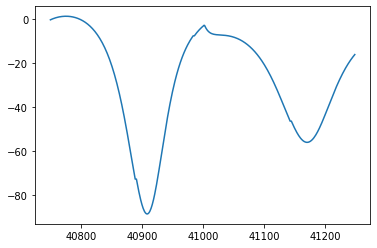

In [103]:
start_index = 0
end_index = 1000000
# start_index = 0
# end_index = 50000
data_test = data[start_index:end_index]
# data_test = data
# data_test.plot(subplots=True, figsize=(16,15))


outlier_key = "f_c"
m = 250
preload_size = 5000
plt.plot(data[40750:41250][outlier_key])
outlier_model = OutlierModel(m=m,std_dev=5,
                             time_series=data_test[:preload_size][outlier_key],
                             egress=True,
                             lag=200,
                             influence=0.5,
                             threshold=5)


# Simulate stream of data
## Inverse transform test dataset for evaluation

In [8]:

# data_test = pd.DataFrame(models["scaler"].inverse_transform(data_test_scaled.drop(columns=cat_cols + [identifier,target])),
#                columns=data_test_scaled.drop(columns=cat_cols + [identifier,target]).columns.values)
# data_test[[identifier,target]] = data_test_scaled[[identifier,target]].copy()

In [9]:
data_test.head()

,f_c,P,m_d,m_q,theta,P_ref,V_DC,V_phaseA,V_phaseB,V_phaseC,I_phaseA,I_phaseB,I_phaseC,fault,sample_id
0,0.160401,102708.459241,311.0,0.0,-163.738242,2500.0,800.0,-259.299072,-19.057368,278.356440,294.335345,-928.391542,634.056197,0,0
1,0.267618,102492.887801,311.0,0.0,-163.738192,2500.0,800.0,-259.696384,-18.337809,278.034193,284.639238,-916.942492,632.303254,0,1
2,0.369417,102288.207648,311.0,0.0,-163.738108,2500.0,800.0,-260.114450,-17.577815,277.692264,274.799672,-905.428051,630.628379,0,2
3,0.465867,102094.284312,311.0,0.0,-163.737992,2500.0,800.0,-260.553771,-16.775993,277.329764,264.816484,-893.849302,629.032819,0,3
4,0.557028,101910.993770,311.0,0.0,-163.737845,2500.0,800.0,-261.014849,-15.930912,276.945761,254.689537,-882.207299,627.517762,0,4


* loading the whole DL model with preprocessors in each iteration is stupid but I wanted to send Alex at least some initial code


In [104]:
fault = False
for index, row in data_test[preload_size:].iterrows():
    if index % 10000 == 0:
        print(f"Current Global index: {index}")
    if not fault:
        outlier_model.train_one(row[outlier_key])
        outlier_model.predict_one(index)
        # print("fault start")
    else:
        # predicted = pipeline.predict(row, column_types_loc, save_loc)
        print("fault continues")
        # if predicted == 0:
        #     fault = False
        #     print("fault ended")

12/06/2021 01:14:49 PM:  Anomaly at Global index: 6140
12/06/2021 01:14:49 PM: max_mp: 7.2201, metric:7.2079: metric-max_mp: 0.012199999999999989
12/06/2021 01:14:53 PM:  Anomaly at Global index: 16140
12/06/2021 01:14:53 PM: max_mp: 8.7234, metric:8.415099999999999: metric-max_mp: 0.3083000000000009
12/06/2021 01:14:57 PM:  Anomaly at Global index: 26140
12/06/2021 01:14:57 PM: max_mp: 5.9399, metric:4.1901: metric-max_mp: 1.7497999999999996
12/06/2021 01:15:01 PM:  Anomaly at Global index: 36140
12/06/2021 01:15:01 PM: max_mp: 13.7448, metric:13.0764: metric-max_mp: 0.6684000000000001
12/06/2021 01:15:04 PM:  Anomaly at Global index: 46140
12/06/2021 01:15:04 PM: max_mp: 30.8707, metric:16.8686: metric-max_mp: 14.002099999999999
12/06/2021 01:15:07 PM:  Anomaly at Global index: 58706
12/06/2021 01:15:07 PM: max_mp: 3.3937, metric:3.3813999999999997: metric-max_mp: 0.0123000000000002
12/06/2021 01:15:10 PM:  Anomaly at Global index: 69424
12/06/2021 01:15:10 PM: max_mp: 5.6402, metric

Current Global index: 10000
Current Global index: 20000
Current Global index: 30000
Current Global index: 40000
Current Global index: 50000
Current Global index: 60000
Current Global index: 70000
Current Global index: 80000
Current Global index: 90000
Current Global index: 100000
Current Global index: 110000
Current Global index: 120000
Current Global index: 130000
Current Global index: 140000
Current Global index: 150000
Current Global index: 160000
Current Global index: 170000
Current Global index: 180000
Current Global index: 190000
Current Global index: 200000
Current Global index: 210000
Current Global index: 220000
Current Global index: 230000
Current Global index: 240000
Current Global index: 250000
Current Global index: 260000
Current Global index: 270000
Current Global index: 280000
Current Global index: 290000
Current Global index: 300000
Current Global index: 310000
Current Global index: 320000
Current Global index: 330000
Current Global index: 340000
Current Global index: 3

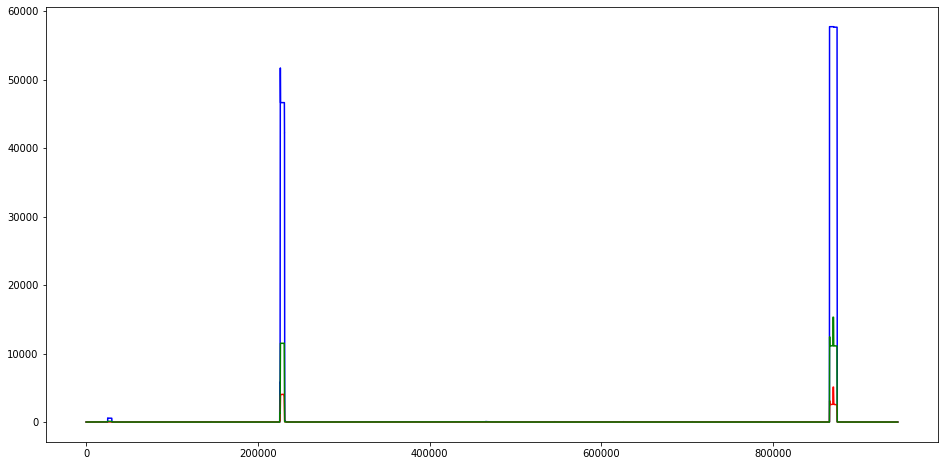

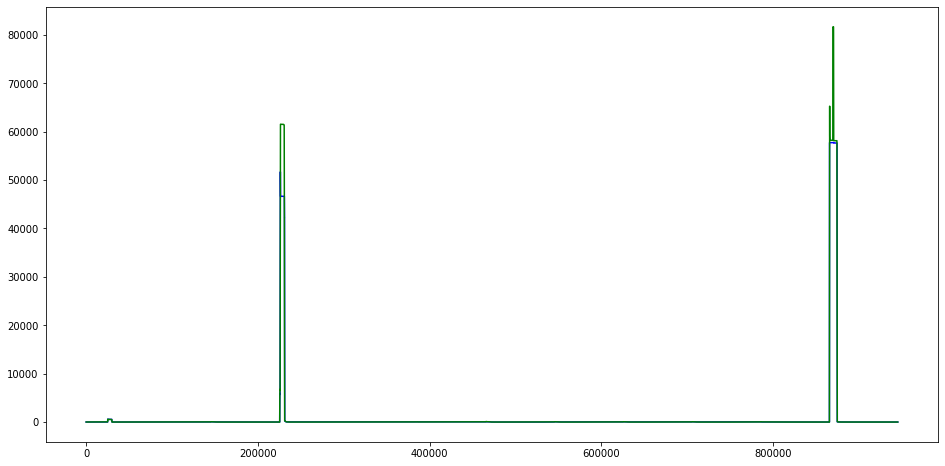

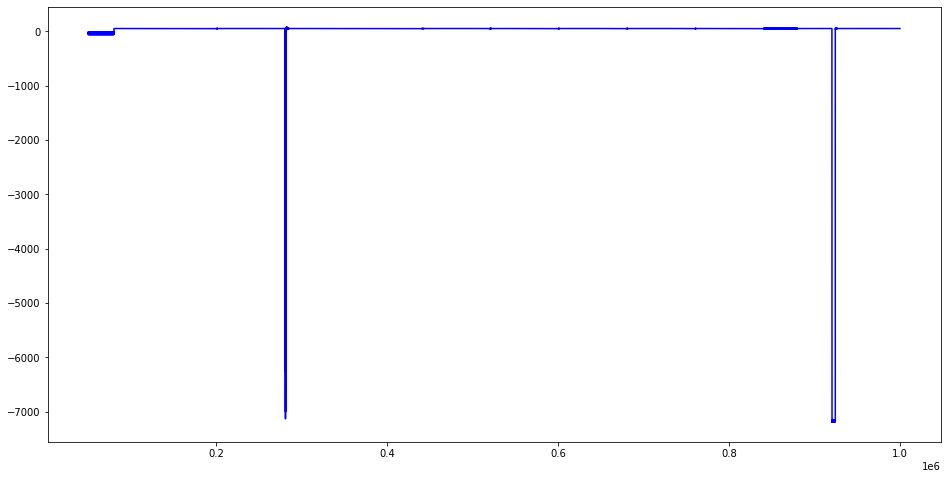

In [101]:
# plt.figure(figsize=(16,8))
# plt.plot(data[23500:27500][outlier_key])
plt.figure(figsize=(16,8))

plt.plot(outlier_model.max_val,'b-',
         outlier_model.max_mean,'r-',
         outlier_model.max_std_dev,'g-')
# plt.plot(outlier_model.max_std_dev)
plt.figure(figsize=(16,8))
plt.plot(#outlier_model.comparisson, 'r-',
         outlier_model.max_val,'b-',
         # outlier_model.avgFilter,'r-',
         outlier_model.stdFilter,'g-')

plt.figure(figsize=(16,8))
# plt.plot(data_test["fault"])
plt.plot(data_test[outlier_key], 'b-',outlier_model.comparisson, 'r-')

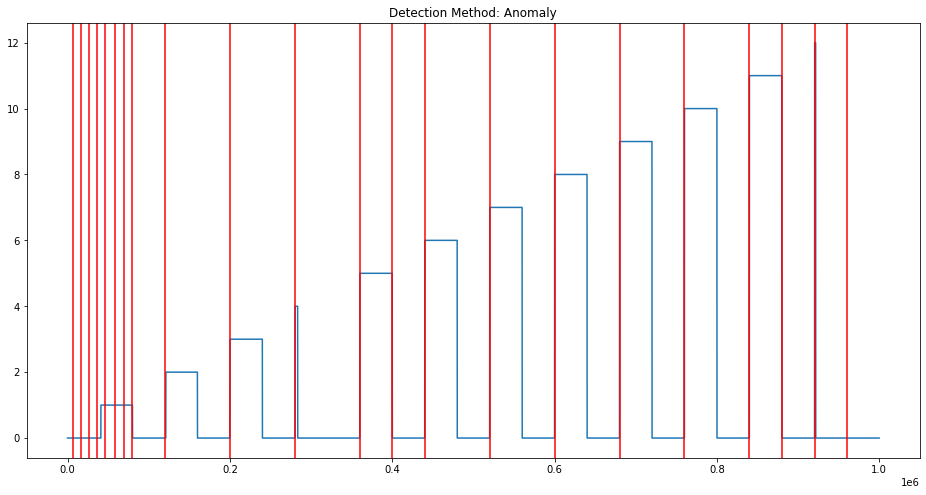

In [105]:
plt.figure(figsize=(16,8))
plt.plot(data_test["fault"])
plt.title(f"Detection Method: Anomaly")
for i in outlier_model.anomalies:
    plt.axvline(x=i,color='r')